In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import scipy
import re
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.preprocessing as preprocessing
from collections import Counter

from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import *

#ZeroPadding3D
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from pyts.image import RecurrencePlot
import shutil


%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3052951066440532673
]


In [3]:
top = "C:\\Users\\jagat\\Desktop\\Masters\\Team Project/USC-HAD/USC-HAD/USC-HAD/" 

In [4]:
df_num = 0
for root, dirs, files in os.walk(top, topdown=True):
  for file in files:
    if '.mat' in file:
      df_num += 1
print(df_num)

840


In [5]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  0
2.6.0


'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [6]:
dataframe_list = []

for root, dirs, files in os.walk(top, topdown=True):
  # print('root:',root)
  # print('dirs:',dirs)
  # print('files:',files)
  for file in files:
    if '.mat' in file:
      sensor_readings = []
      acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z = [],[],[],[],[],[]
      D = loadmat(os.path.join(root, file))
      popKeys = ['__header__', '__globals__','__version__','title','version','date','trial','sensor_location','sensor_orientation']
      for k in popKeys:
        D.pop(k)

      sensor_readings.append(D['sensor_readings'])

      for readings in sensor_readings[0]:
        acc_x.append(readings[0]) 
        acc_y.append(readings[1])
        acc_z.append(readings[2])
        gyro_x.append(readings[3])
        gyro_y.append(readings[4])
        gyro_z.append(readings[5])

      dict_sensor_readings = {'acc_x':acc_x, 'acc_y':acc_y, 'acc_z':acc_z, 'gyro_x':gyro_x, 'gyro_y':gyro_y, 'gyro_z':gyro_z}
      data = pd.DataFrame(dict_sensor_readings)

      pattern = r'^[0-9]*'
      column_name = ['age', 'height', 'weight', 'subject', 'label']
      heights = re.findall(pattern, D['height'][0])[0]
      weights = re.findall(pattern, D['weight'][0])[0]
      ages = D['age'][0]
      subjects = D['subject'][0]
      if D.get("activity_number") is None:
        activity_numbers = '404'
      else:
        activity_numbers = D['activity_number'][0]
      values = [ages, heights, weights, subjects, activity_numbers]
      zip_ = zip(column_name, values)
      for col_name, value in zip_:
        data[col_name] = value
      
      dataframe_list.append(data)
      


In [7]:
len(dataframe_list)

840

In [8]:
dataframe_final = {}
for i in range(df_num):
  dataframe_final[i] = dataframe_list[i]

df_raw = pd.concat(dataframe_final.values(), ignore_index=True)

In [9]:
print(len(df_raw))
df = df_raw[(df_raw.label != '404')]
print(len(df))

2811490
2809281


In [10]:
df.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,age,height,weight,subject,label
0,-0.653698,0.711878,-0.423886,-0.203916,-0.309533,-0.464422,27,164,43,1,10
1,-0.646831,0.708259,-0.420226,0.103647,-0.161285,-0.241990,27,164,43,1,10
2,-0.650265,0.711878,-0.423886,0.069611,-0.108322,-0.162525,27,164,43,1,10
3,-0.646831,0.711878,-0.423886,0.352995,0.220050,0.179550,27,164,43,1,10
4,-0.643397,0.711878,-0.427546,0.279527,0.174251,0.142181,27,164,43,1,10


In [11]:
df.head()
df.isnull().sum()

acc_x      0
acc_y      0
acc_z      0
gyro_x     0
gyro_y     0
gyro_z     0
age        0
height     0
weight     0
subject    0
label      0
dtype: int64

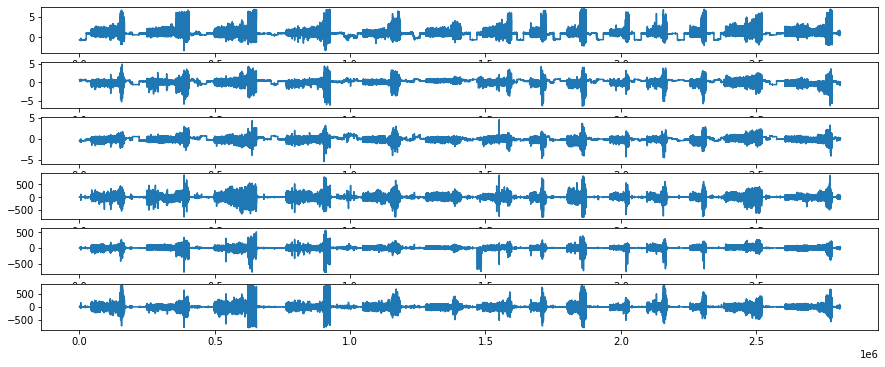

In [12]:
plt.figure(figsize=(15,9))
plt.subplot(9,1,1)
plt.plot(df["acc_x"])
plt.subplot(9,1,2)
plt.plot(df["acc_y"])
plt.subplot(9,1,3)
plt.plot(df["acc_z"])
plt.subplot(9,1,4)
plt.plot(df["gyro_x"])
plt.subplot(9,1,5)
plt.plot(df["gyro_y"])
plt.subplot(9,1,6)
plt.plot(df["gyro_z"])
plt.show()

In [13]:
df_acc = pd.DataFrame(df, columns=['acc_x', 'acc_y', 'acc_z'])
print(df_acc.head())
df_gyro = pd.DataFrame(df, columns=['gyro_x', 'gyro_y', 'gyro_z'])
print(df_gyro.head())

      acc_x     acc_y     acc_z
0 -0.653698  0.711878 -0.423886
1 -0.646831  0.708259 -0.420226
2 -0.650265  0.711878 -0.423886
3 -0.646831  0.711878 -0.423886
4 -0.643397  0.711878 -0.427546
     gyro_x    gyro_y    gyro_z
0 -0.203916 -0.309533 -0.464422
1  0.103647 -0.161285 -0.241990
2  0.069611 -0.108322 -0.162525
3  0.352995  0.220050  0.179550
4  0.279527  0.174251  0.142181


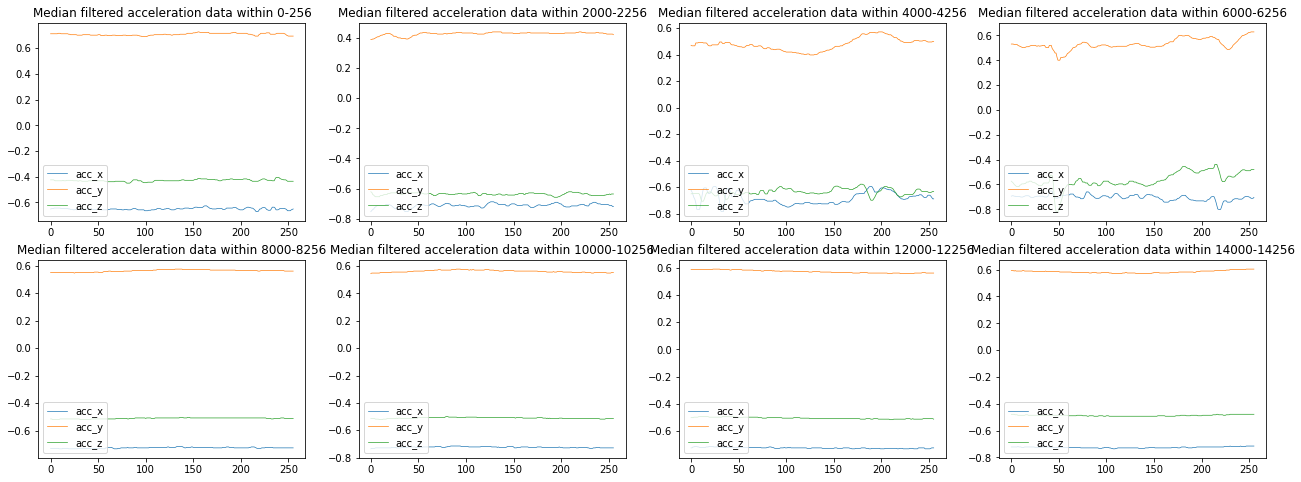

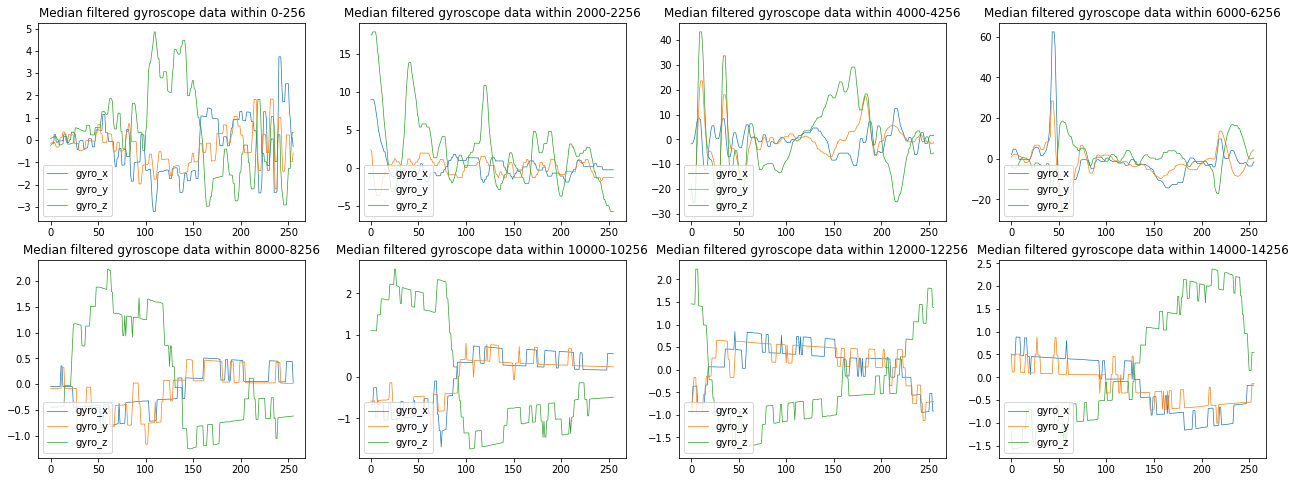

In [14]:
# Apply median filter with filter length 5.
df_med_acc = df_acc.rolling(window=5, center=True, min_periods=1).median()
df_med_gyro = df_gyro.rolling(window=5, center=True, min_periods=1).median()

# Plot acceleration data every 256 readings (2.56 sec) with median filter
f, ax = plt.subplots(2, 4, figsize=(22, 8))
ax = ax.flatten()
for i in range(8):
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        ax[i].plot(df_med_acc.iloc[i*2000:i*2000+256][axis].values, label=axis, linewidth=0.7)
    ax[i].set_title(f"Median filtered acceleration data within {i*2000}-{i*2000+256}")
    ax[i].legend(loc='lower left')
plt.show()


# Plot raw gyroscope data (100Hz) every 256 readings (2.56 sec) with median filter
f, ax = plt.subplots(2, 4, figsize=(22, 8))
ax = ax.flatten()
for i in range(8):
    for axis in ['gyro_x', 'gyro_y', 'gyro_z']:
        ax[i].plot(df_med_gyro.iloc[i*2000:i*2000+256][axis].values, label=axis, linewidth=0.7)
    ax[i].set_title(f"Median filtered gyroscope data within {i*2000}-{i*2000+256}")
    ax[i].legend(loc='lower left')
plt.show()

In [15]:
# Apply 3rd order low pass Butterworth filter with a corner frequency of 20 Hz.
from scipy import signal
fs = 50  # sampling frequency
fc = 20  # cutoff frequency

w = fc / (fs / 2)  # Normalize the frequency
b, a = signal.butter(3, w, 'low')  # 3rd order low pass Butterworth filter

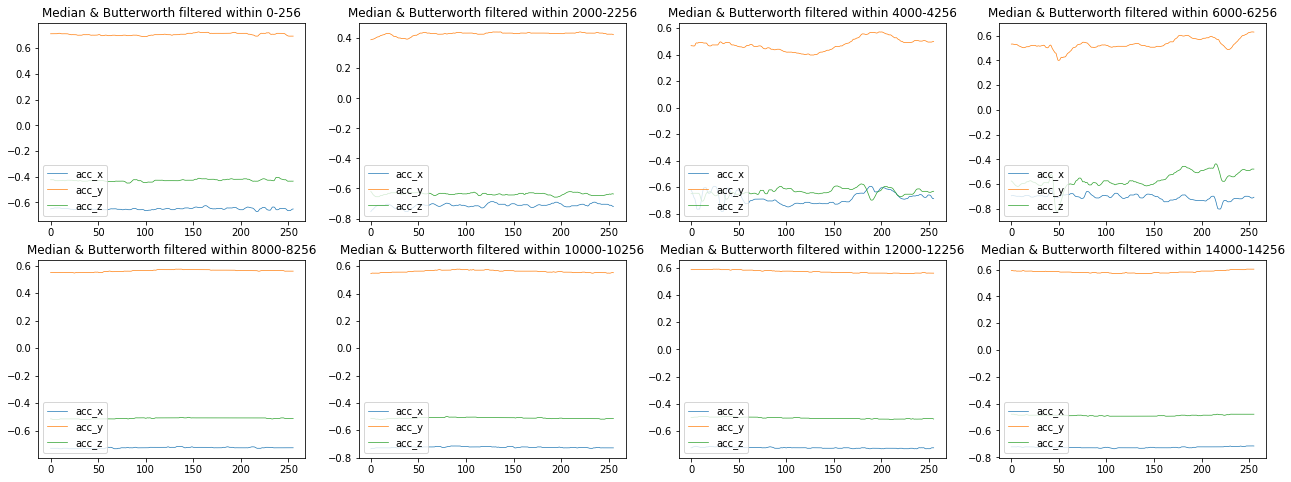

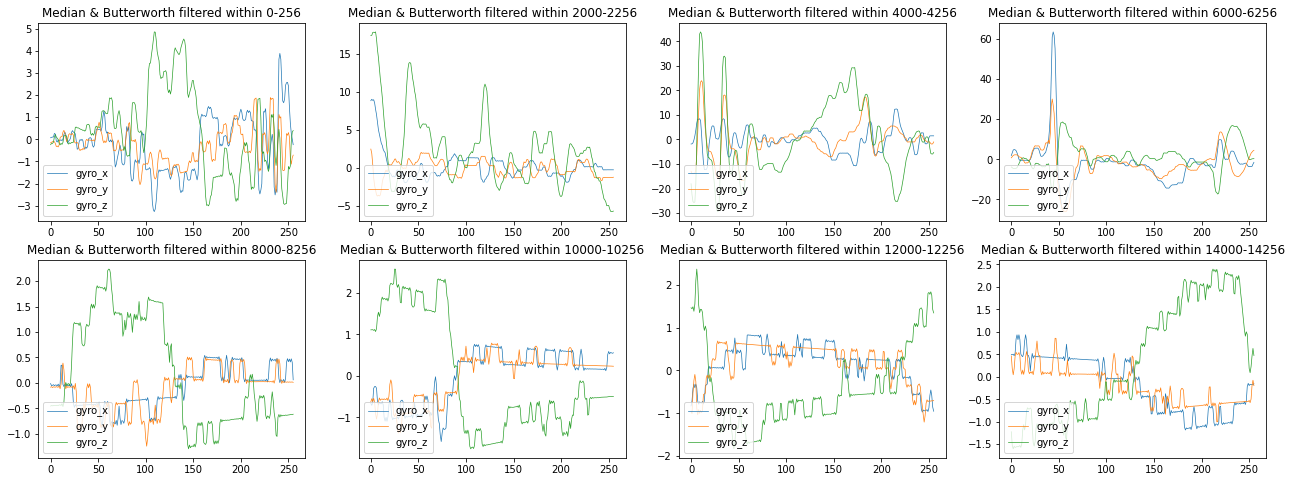

In [16]:
df_acc_med_but = pd.DataFrame(signal.filtfilt(b, a, df_med_acc, axis=0), columns=['acc_x', 'acc_y', 'acc_z'])
df_gyro_med_but = pd.DataFrame(signal.filtfilt(b, a, df_med_gyro, axis=0), columns=['gyro_x', 'gyro_y', 'gyro_z'])

# Plot acceleration data within 256 readings (2.56 sec) with median filter & Butterworth filter
f, ax = plt.subplots(2, 4, figsize=(22, 8))
ax = ax.flatten()
for i in range(8):
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        ax[i].plot(df_acc_med_but.iloc[i*2000:i*2000+256][axis].values, label=axis, linewidth=0.7)
    ax[i].set_title(f"Median & Butterworth filtered within {i*2000}-{i*2000+256}")
    ax[i].legend(loc='lower left')
plt.show()


# Plot raw gyroscope data (100Hz) within 256 readings (2.56 sec) with median filter & Butterworth filter
f, ax = plt.subplots(2, 4, figsize=(22, 8))
ax = ax.flatten()
for i in range(8):
    for axis in ['gyro_x', 'gyro_y', 'gyro_z']:
        ax[i].plot(df_gyro_med_but.iloc[i*2000:i*2000+256][axis].values, label=axis, linewidth=0.7)
    ax[i].set_title(f"Median & Butterworth filtered within {i*2000}-{i*2000+256}")
    ax[i].legend(loc='lower left')
plt.show()

In [17]:
# Calculate the magnitude of three-dimensional signals using the Euclidean norm.
from numpy.linalg import norm

acc_med_but_mag = norm(df_acc_med_but, ord=2, axis=1)
gyro_med_but_mag = norm(df_gyro_med_but, ord=2, axis=1)

print(acc_med_but_mag.shape)
print(gyro_med_but_mag.shape)

(2809281,)
(2809281,)


In [18]:
N = 256
dt = 0.01  # 100Hz
t = np.arange(0, N*dt, dt)  # time axis
freq = np.linspace(0, 1.0 / dt, N)  # frequency axis
win = np.hamming(N)  # hamming window

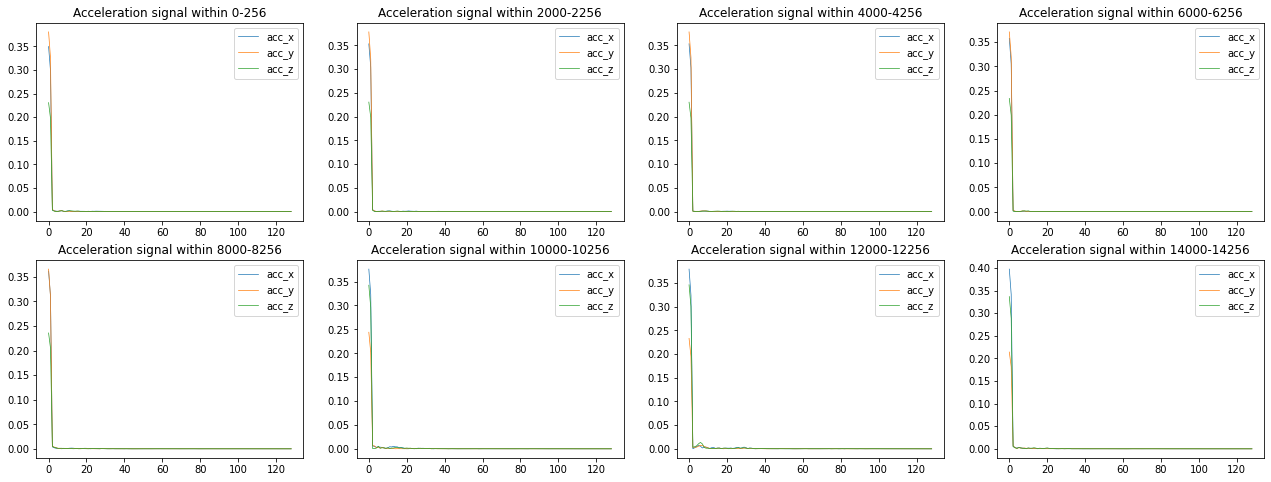

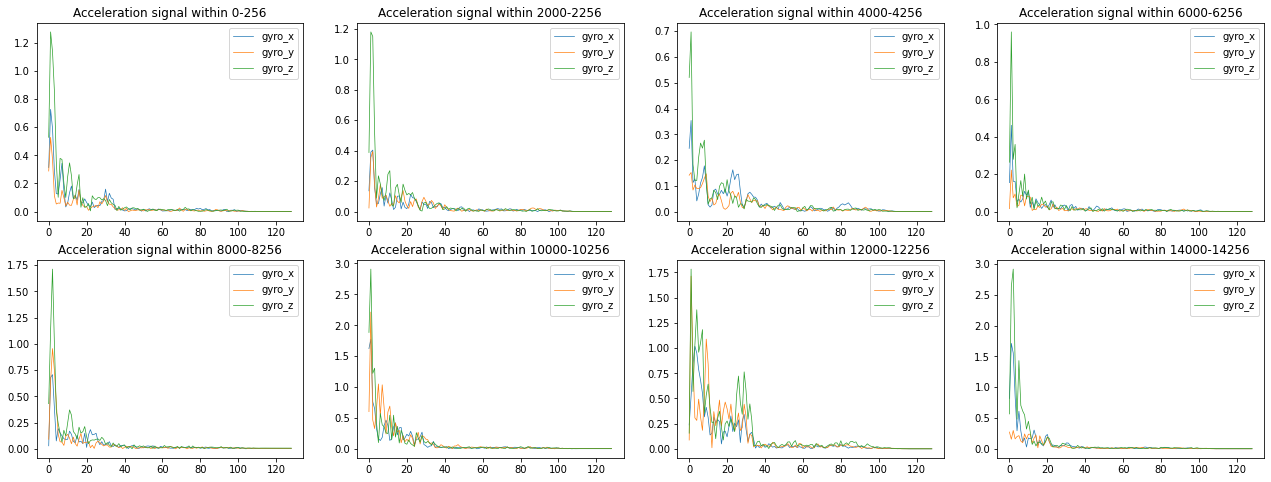

In [19]:
# Plot with hamming
f, ax = plt.subplots(2, 4, figsize=(22, 8))
ax = ax.flatten()
for i in range(8):
    df_acc_fft = pd.DataFrame(columns=['acc_x', 'acc_y', 'acc_z'])
    
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        df_acc_fft[axis] = df_acc_med_but.iloc[i*256:i*256+256][axis] * win
    
    F = np.fft.fft(df_acc_fft, axis=0)
    F = pd.DataFrame(F, columns=['acc_x', 'acc_y', 'acc_z'])
    
    F = F[:N//2+1]

    # Calculare amplitude spectrum
    Amp_acc = np.abs(F)
    Amp_acc = pd.DataFrame(Amp_acc, columns=['acc_x', 'acc_y', 'acc_z'])
    
    Amp_acc = Amp_acc / N * 2
    Amp_acc.iloc[0] = Amp_acc.iloc[0] / 2
        
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        ax[i].plot(Amp_acc[axis].values, label=axis, linewidth=0.7)
        
    ax[i].set_title(f"Acceleration signal within {i*2000}-{i*2000+256}")
    ax[i].legend(loc='upper right')

# Plot with hamming
f, ax = plt.subplots(2, 4, figsize=(22, 8))
ax = ax.flatten()
for i in range(8):
    df_gyro_fft = pd.DataFrame(columns=['gyro_x', 'gyro_y', 'gyro_z'])
    
    for axis in ['gyro_x', 'gyro_y', 'gyro_z']:
        df_gyro_fft[axis] = df_gyro_med_but.iloc[i*256:i*256+256][axis] * win
    
    F = np.fft.fft(df_gyro_fft, axis=0)
    F = pd.DataFrame(F, columns=['gyro_x', 'gyro_y', 'gyro_z'])
    
    F = F[:N//2+1]

    # Calculare amplitude spectrum
    Amp_gyro = np.abs(F)
    Amp_gyro = pd.DataFrame(Amp_gyro, columns=['gyro_x', 'gyro_y', 'gyro_z'])
    
    Amp_gyro = Amp_gyro / N * 2
    Amp_gyro.iloc[0] = Amp_gyro.iloc[0] / 2
        
    for axis in ['gyro_x', 'gyro_y', 'gyro_z']:
        ax[i].plot(Amp_gyro[axis].values, label=axis, linewidth=0.7)
        
    ax[i].set_title(f"Acceleration signal within {i*2000}-{i*2000+256}")
    ax[i].legend(loc='upper right')
plt.show()

In [20]:
def window_segments_label_segments(df_data, windows, steps):
  num_features = 6
  window_segments = []
  label_segments = []

  for i in range(0, len(df_data)-windows, steps):
    acc_x = df_data['acc_x'].values[i: i+windows]
    acc_y = df_data['acc_y'].values[i: i+windows]
    acc_z = df_data['acc_z'].values[i: i+windows]
    gyro_x = df_data['gyro_x'].values[i: i+windows]
    gyro_y = df_data['gyro_y'].values[i: i+windows]
    gyro_z = df_data['gyro_z'].values[i: i+windows]
    _label = df_data['label'].values[i: i+windows]
    label = Counter(_label).most_common()[0][0]
    window_segments.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
    label_segments.append(label)

  window_segments_reshape = np.asarray(window_segments, dtype= np.float32).transpose(0,2,1)#(-1, windows, num_features)
  label_segments = np.asarray(label_segments)

  return window_segments_reshape, label_segments

In [21]:
# 50% overlap
windows = 128
steps = 64
X_fin, y_fin = window_segments_label_segments(df, windows, steps)

In [22]:
print(len(X_fin))
print(len(X_fin[0]))
print(X_fin.shape)
print(X_fin[0].shape)
print(y_fin.shape)

43894
128
(43894, 128, 6)
(128, 6)
(43894,)


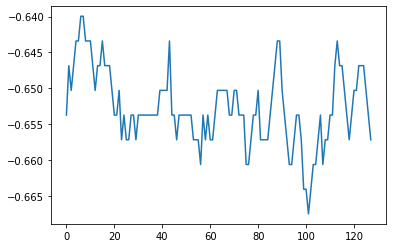

In [23]:
plt.plot(X_fin[0][:,0])

In [24]:
y_tr = to_categorical(y_fin)
final_Y = np.delete(y_tr,0,1)
final_Y.shape

(43894, 12)

In [25]:
np.random.seed(42)
rand_indices= np.random.permutation(X_fin.shape[0])
X_fin= X_fin[rand_indices]
final_Y= final_Y[rand_indices]

#80,20 split
split= int(0.5*final_Y.shape[0])
train_split= rand_indices[:split]
test_split= rand_indices[split:]

In [26]:
X_train= X_fin[train_split]
X_test= X_fin[test_split]
Y_train= final_Y[train_split]
Y_test= final_Y[test_split]

In [27]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((21947, 128, 6), (21947, 12), (21947, 128, 6), (21947, 12))

In [28]:
def plot_graphs(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy") 
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.show()

    train_acc = history.history['loss']
    val_acc = history.history['val_loss']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Loss") 
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.show()

def calc_scores(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    return len(train_acc),train_acc[-1]*100,val_acc[-1]*100

scores=np.zeros(shape=(7,3))

In [29]:
X_train_base= X_train.reshape(-1,32,24) #(-1,X_train.shape[1]*X_train.shape[2])
X_test_base= X_test.reshape(-1,32,24) #reshape(-1,X_test.shape[1]*X_test.shape[2])
x1,x2,x3= X_train_base.shape
X_train_base=X_train_base.reshape(x1,x2,x3,1)
X_test_base=X_test_base.reshape(x1,x2,x3,1)
x1,x2,x3

(21947, 32, 24)

Model: "CNN_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 20, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 28, 20, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 20, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 10, 32)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 16, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 10, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 10, 64)        0

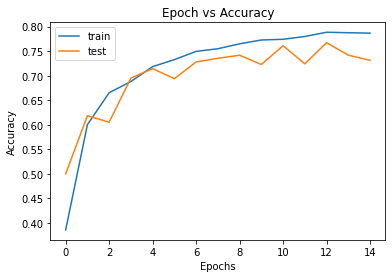

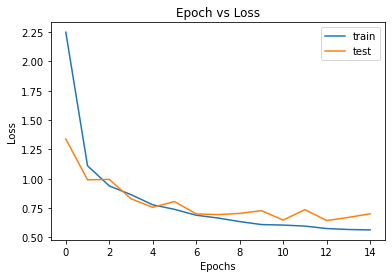

In [30]:

np.random.seed(0) 
model_simple_CNN = models.Sequential(name = 'CNN_simple') 

#model_simple_CNN.build(input_shape=(x2, x3, 1))
#model_simple_CNN.add(layers.ZeroPadding2D(padding=(2, 2)))
model_simple_CNN.add(Conv2D(32,(5, 5), activation='selu', input_shape=(x2, x3, 1)))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(MaxPooling2D((2,2)))
model_simple_CNN.add(layers.ZeroPadding2D(padding=(1, 1)))
model_simple_CNN.add(Conv2D(64,(3, 3), activation='selu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(layers.ZeroPadding2D(padding=(1, 1)))
model_simple_CNN.add(Conv2D(16,(3, 3), activation='selu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(layers.Flatten())
#model_simple_CNN.add(layers.Dense(3072, activation='relu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(layers.Dense(1536, activation='relu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(layers.Dense(12, activation='softmax'))


print(model_simple_CNN.summary())
model_simple_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_simple_CNN.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_simple_CNN.fit(X_train_base, Y_train , epochs=15, 
                    validation_data=(X_test_base, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[0,:]=calc_scores(history)

In [31]:
np.random.seed(0)
model_LSTM = Sequential(name = 'LSTM')
model_LSTM.add(LSTM(512, recurrent_dropout=0.5, input_shape=(None, X_train.shape[2]))) 
model_LSTM.add(Dense(100, activation='relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dense(12, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
print(model_LSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_LSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_LSTM.fit(X_train, Y_train , epochs=15, 
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[1,:]=calc_scores(history)

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1062912   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1212      
Total params: 1,115,824
Trainable params: 1,115,624
Non-trainable params: 200
_________________________________________________________________
None
Epoch 1/15
 90/686 [==>...........................] - ETA: 17:42 - loss: 2.2565 - accuracy: 0.2788

KeyboardInterrupt: 

In [ ]:
np.random.seed(0)
model_biLSTM = Sequential(name = 'bidirectional_LSTM')
model_biLSTM.add(Bidirectional(LSTM(512, recurrent_dropout=0.5), input_shape=(None, X_train.shape[2])))
model_biLSTM.add(Dense(100, activation='relu'))
model_biLSTM.add(Dropout(0.5))
model_biLSTM.add(BatchNormalization())
model_biLSTM.add(Dense(12, activation='softmax'))
model_biLSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
print(model_biLSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_biLSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_biLSTM.fit(X_train, Y_train , epochs=15,
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[2,:]=calc_scores(history)

In [ ]:
acv=X_train[0,:,3]
plt.plot(acv)
plt.show()
factor=4
k=int(len(acv)/factor)
transformer1 = MarkovTransitionField(image_size=1/factor, n_bins=4)#,strategy='uniform')
transformer2 = GramianAngularField(image_size=1/factor)
transformer3 = RecurrencePlot()#threshold=0.5)
transformer4 = RecurrencePlot()#threshold=10)
p=transformer1.transform(acv.reshape(1,-1))
q=transformer2.transform(acv.reshape(1,-1))
r=transformer4.transform(acv.reshape(1,-1))
print(p.shape)
plt.imshow(p.reshape(k,k));
plt.show()
plt.imshow(q.reshape(k,k));
plt.show()
plt.imshow(r.reshape(factor*k,factor*k));
plt.show()
avg_filt=layers.AveragePooling2D((factor, factor))
plt.imshow(avg_filt(r.reshape(1,len(acv),len(acv),1)).reshape(k,k));

In [ ]:
import warnings

#suppress warnings like RunTime error
warnings.filterwarnings('ignore')

In [ ]:
def new_X_MTF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]), dtype=np.float32)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer1.transform(dt.reshape(1,-1))
            Xp[i,:,:,j]=img
    return Xp

X_MTF_train=new_X_MTF(X_train)
X_MTF_test=new_X_MTF(X_test)
x1,x2,x3,x4= X_MTF_train.shape
X_MTF_train=X_MTF_train.reshape(x1,x2,x3,x4,1)
X_MTF_test=X_MTF_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)

model_MTF = models.Sequential()
model_MTF.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))#, 1)))
model_MTF.add(BatchNormalization())
model_MTF.add(layers.MaxPooling3D((2, 2, 1)))
#model_MTF.add(Dropout(0.5))
model_MTF.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_MTF.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
#model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Conv3D(100, (4, 4, 1), activation='selu'))
model_MTF.add(layers.Flatten())
#model_MTF.add(Dropout(0.5))
#model_MTF.add(layers.Dense(100, activation='relu'))
#model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Dense(12, activation='softmax'))
print(model_MTF.summary())

model_MTF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_MTF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_MTF.fit(X_MTF_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_MTF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[3,:]=calc_scores(history)

In [ ]:
def new_X_GAF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]), dtype=np.float32)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer2.transform(dt.reshape(1,-1))
            Xp[i,:,:,j]=img
    return Xp

X_GAF_train=new_X_GAF(X_train)
X_GAF_test=new_X_GAF(X_test)
x1,x2,x3,x4= X_GAF_train.shape
X_GAF_train=X_GAF_train.reshape(x1,x2,x3,x4,1)
X_GAF_test=X_GAF_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)
model_GAF = models.Sequential()
model_GAF.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_GAF.add(BatchNormalization())
model_GAF.add(layers.MaxPooling3D((2, 2, 1)))
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_GAF.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Conv3D(100, (4, 4, 1), activation='selu'))
model_GAF.add(layers.Flatten())
#model_GAF.add(Dropout(0.5))
#model_GAF.add(layers.Dense(100, activation='relu'))
#model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Dense(12, activation='softmax'))
print(model_GAF.summary())

model_GAF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_GAF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_GAF.fit(X_GAF_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_GAF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[4,:]=calc_scores(history)

In [ ]:
def new_X_RP(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]), dtype=np.float32)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            if j<3:
                img=transformer3.transform(dt.reshape(1,-1))
            else:
                img=transformer4.transform(dt.reshape(1,-1))
            img=avg_filt(img.reshape(1,len(acv),len(acv),1)).reshape(k,k)
            Xp[i,:,:,j]=img
    return Xp

X_RP_train=new_X_RP(X_train)
X_RP_test=new_X_RP(X_test)
x1,x2,x3,x4= X_RP_train.shape
X_RP_train=X_RP_train.reshape(x1,x2,x3,x4,1)
X_RP_test=X_RP_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)

model_RP = models.Sequential()
model_RP.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_RP.add(BatchNormalization())
model_RP.add(layers.MaxPooling3D((2, 2, 1)))
model_RP.add(Dropout(0.5))
model_RP.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_RP.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_RP.add(Dropout(0.5))
model_RP.add(layers.Conv3D(100, (4, 4, 1), activation='selu'))
model_RP.add(layers.Flatten())
#model_RP.add(Dropout(0.5))
#model_RP.add(layers.Dense(100, activation='relu'))
#model_RP.add(Dropout(0.5))
model_RP.add(layers.Dense(12, activation='softmax'))
print(model_RP.summary())


model_RP.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_RP.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_RP.fit(X_RP_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_RP_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[5,:]=calc_scores(history)

In [ ]:
def new_X_all(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]*3), dtype=np.float32)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img1=transformer1.transform(dt.reshape(1,-1))
            Xp[i,:,:,3*j]=img1
            img2=transformer2.transform(dt.reshape(1,-1))
            Xp[i,:,:,3*j+1]=img2
            if j<3:
                img3=transformer3.transform(dt.reshape(1,-1))
            else:
                img3=transformer4.transform(dt.reshape(1,-1))
            img3=avg_filt(img3.reshape(1,len(acv),len(acv),1)).reshape(k,k)
            Xp[i,:,:,3*j+2]=img3
    return Xp

X_all_img_train=new_X_all(X_train)
X_all_img_test=new_X_all(X_test)
x1,x2,x3,x4= X_all_img_train.shape
X_all_img_train=X_all_img_train.reshape(x1,x2,x3,x4,1)
X_all_img_test=X_all_img_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)
model = models.Sequential()
model.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.5))
model.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model.add(layers.Conv3D(50, (3, 3, 3), activation='selu'))
model.add(Dropout(0.5))
model.add(layers.Conv3D(10, (4, 4, 4), activation='selu'))
model.add(layers.Flatten())
#model.add(Dropout(0.5))
#model.add(layers.Dense(1200, activation='selu'))
#model.add(Dropout(0.5))
#model.add(layers.Dense(120, activation='sigmoid'))
model.add(layers.Dense(12, activation='softmax'))
print(model.summary())


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)
shutil.rmtree('/content/weights', ignore_errors=True)
weights_dir = 'weights/' + model.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model.fit(X_all_img_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_all_img_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[6,:]=calc_scores(history)

In [ ]:
model.evaluate(X_all_img_test, Y_test)

pred = np.argmax(model.predict(X_all_img_test), axis = -1)
confusion = confusion_matrix(np.argmax(Y_test, axis = -1), pred)
NUM_LABELS = 12

f, axes = plt.subplots(1,1, figsize = (12,12))
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.grid(False)
axes.set_xticklabels(class_labels, rotation = 90)
axes.set_yticklabels(class_labels)
axes.set_yticks(list(range(NUM_LABELS)))
axes.set_xticks(list(range(NUM_LABELS)))
plt.imshow(confusion, cmap=plt.cm.Set2, interpolation='nearest')

for i, cas in enumerate(confusion):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

In [ ]:
import pandas as pd
row_names=["CNN simple","LSTM simple","Bidirectional LSTM","MTF image CNN","GAF image CNN","RP image CNN","MTF+GAF+RP image CNN"]
column_names=["Epochs","Training Accuracy %","Test Accuracy %"]
Full_results= pd.DataFrame(scores, index=row_names, columns=column_names)
Full_results